# Multiwavelength astronomy: GALAH meets X-rays

A hands-on tutorial on matching optical and x-ray observations for the [2025 Australia/eROSITA-DE multi-wavelength school](https://astronomyaustralia.org.au/event/2025-australia-erosita-de-multi-wavelength-school/).

This notebook shows you how to crossmatch GALAH DR4 (Buder et al. 2025) with several eROSITA catalogues from VizieR and create some first plots with the overlap.

Author: Sven Buder (ANU, sven.buder@anu.edu.au)

In [1]:
# Read in python packages etc. including required packages: numpy, matplotlib, astropy, astroquery 
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import os

# numpy
import numpy as np

# astropy
from astropy.table import Table, join, hstack
from astropy.coordinates import SkyCoord
import astropy.units as u

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# astroquery
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1 # Make sure we download all rows, not just the default first 50

## 1 GALAH DR4

Paper: https://ui.adsabs.harvard.edu/abs/2024arXiv240919858B  
Table: https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/catalogs/galah_dr4_allstar_240705.fits

In [2]:
# Read in GALAH DR4 as *galah_allstar* 
try:
    galah_allstar = Table.read('data/galah_dr4_allstar_240705.fits')
except:
    # Fall-back option for the multi wavelength school
    galah_allstar = Table.read('data/galah_dr4_allstar_240705_ids_only.fits')

## 2 Example: Candidate CVs and AM CVns out to 1000pc (Rodriguez et al., 2025)

Paper: https://ui.adsabs.harvard.edu/abs/2025PASP..137a4201R  
Table: J/PASP/137/A4201/cv_1000 @ VizieR

In [3]:
# Download the catalogue from VizieR
cv_1000 = Vizier.get_catalogs('J/PASP/137/A4201/cv_1000')[0]

# Crossmatch via common gaiadr3_source_id
cv_1000.rename_column('GaiaDR3','gaiadr3_source_id')
galah_cv_1000 = join(cv_1000, galah_allstar, keys='gaiadr3_source_id')

len(galah_cv_1000)

3

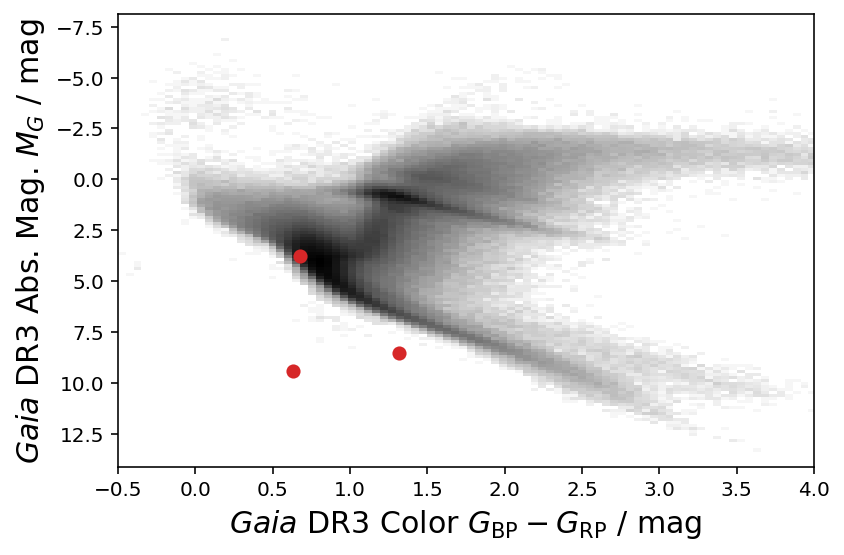

In [4]:
# Where are these stars?
def plot_gaia_hrd(): 
    try:
        finite_distances = np.isfinite(galah_allstar['r_med']) & np.isfinite(galah_allstar['bp_rp'])

        f, ax = plt.subplots()
        ax.hist2d(
            galah_allstar['bp_rp'][finite_distances],
            galah_allstar['phot_g_mean_mag'][finite_distances] - 5*np.log10(galah_allstar['r_med'][finite_distances]/10),
            bins = 150, norm=LogNorm(),
            cmin = 1, cmap = 'Greys', zorder=1
        );
        ax.scatter(
            galah_cv_1000['BP-RP'],
            galah_cv_1000['Gmag'] + 5*np.log10(galah_cv_1000['Plx']/100),
            s = 50, zorder=2, lw=0, c = 'C3'
        );
        ax.set_xlim(-0.5,4.0)
        ax.set_ylim(ax.get_ylim()[::-1])

        ax.set_xlabel(r'$Gaia$ DR3 Color $G_\mathrm{BP} - G_\mathrm{RP}~/~\mathrm{mag}$',fontsize=15)
        ax.set_ylabel(r'$Gaia$ DR3 Abs. Mag. $M_G~/~\mathrm{mag}$',fontsize=15)

        plt.tight_layout()
        plt.show()
        plt.close()

    except:
        pass
plot_gaia_hrd()

In [ ]:
# Let's try to download the GALAH data products (some may not exist if the pipeline was not run successfully.)
def download_galah_data_products(sobject_id):
    os.makedirs('galah_data/'+str(sobject_id),exist_ok=True)
    
    # Try to download the radial velocity comparison of repeat observations and Gaia
    os.system('wget --no-clobber -P galah_data/'+str(sobject_id)+' https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_allstar_rv_comparison.png')
    
    # Try to download the radial velocity fit
    os.system('wget --no-clobber -P galah_data/'+str(sobject_id)+' https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_allstar_fit_rv.png')

    # Try to download the spectrum
    os.system('wget --no-clobber -P galah_data/'+str(sobject_id)+' https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_allstar_fit_spectrum.fits')
    
    # Try to download the quick-view comparison
    os.system('wget --no-clobber -P galah_data/'+str(sobject_id)+' https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR4/analysis_products_allstar/'+str(sobject_id)[:6]+'/'+str(sobject_id)+'/'+str(sobject_id)+'_allstar_fit_comparison.pdf')

for sobject_id in galah_cv_1000['sobject_id']:
    download_galah_data_products(sobject_id)

Loaded spectrum for 150411003101372/ Gaia DR3 3599772726850899712


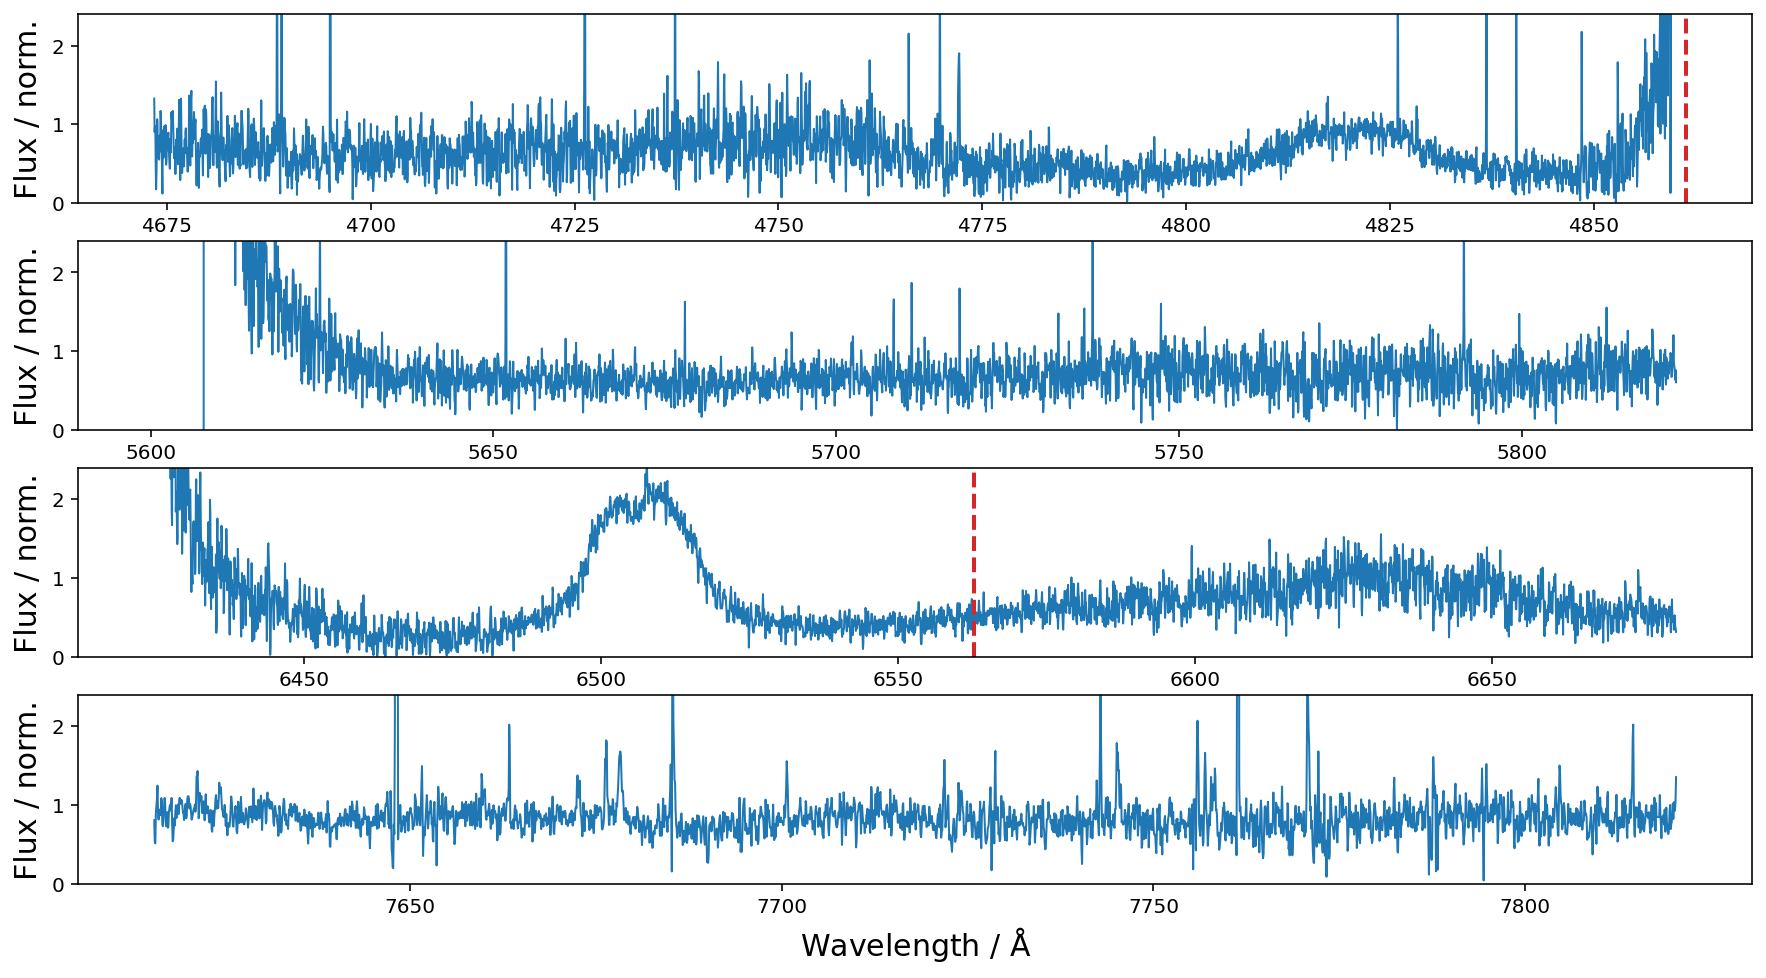

Loaded spectrum for 210919003601115/ Gaia DR3 4724321333902723072


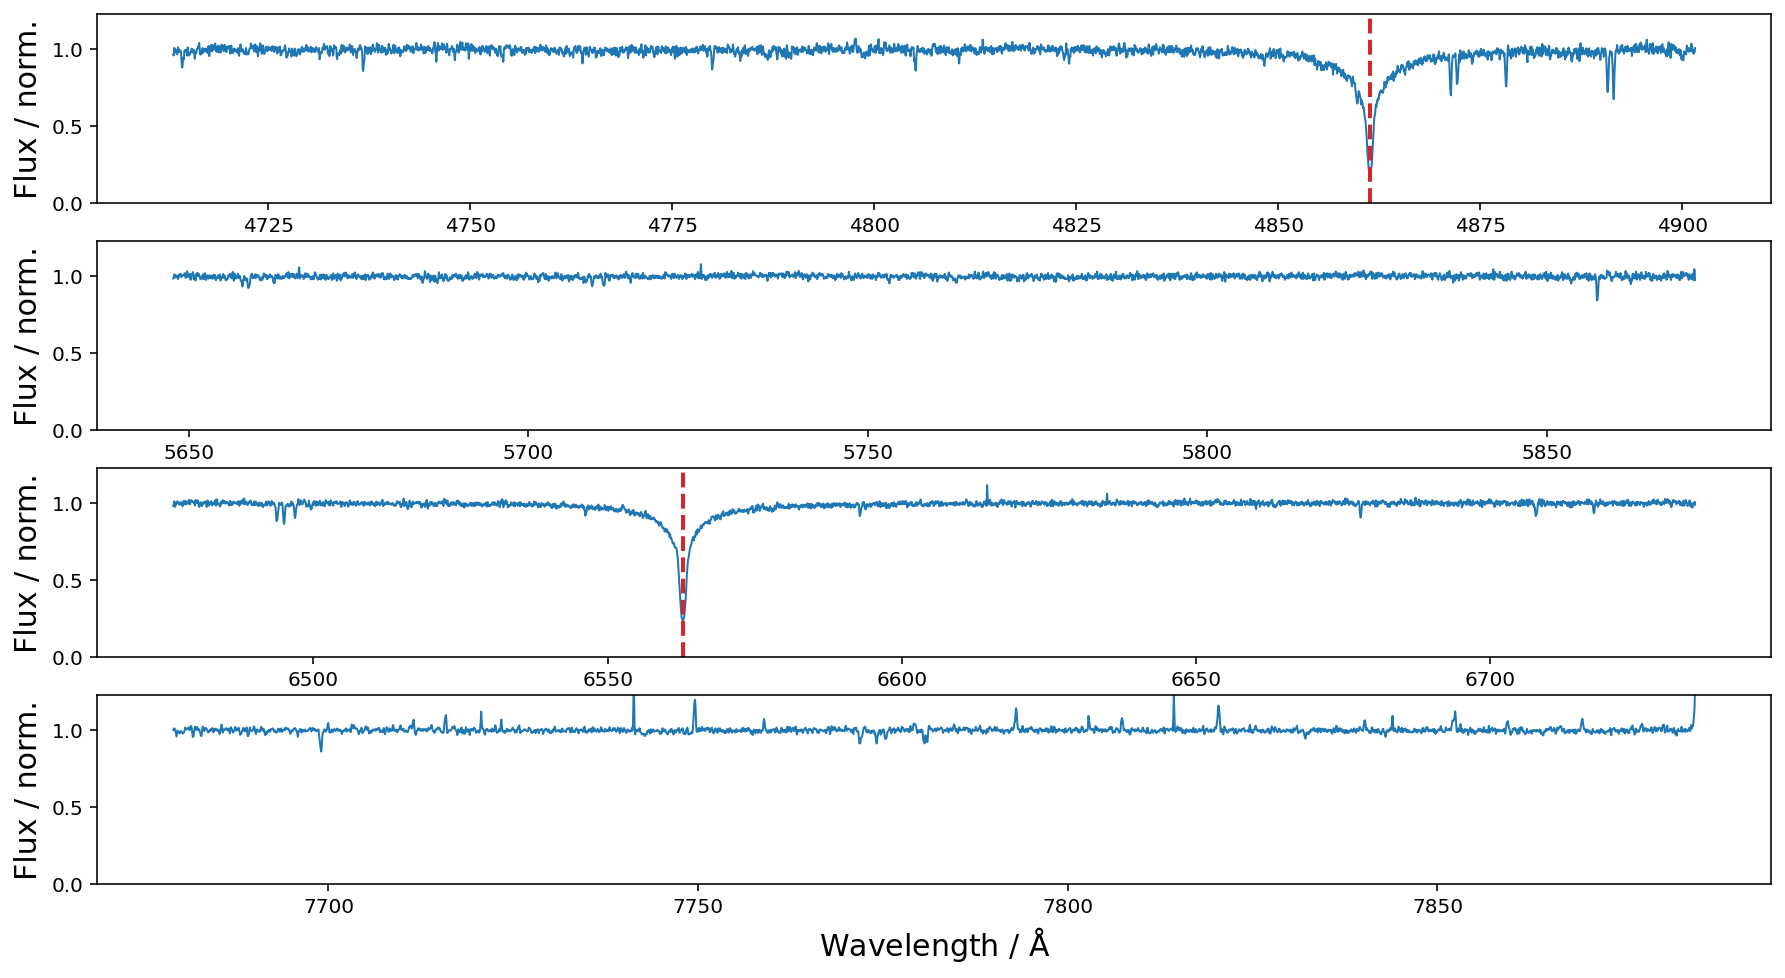

Could not load/plot spectrum for 170218003701004


In [6]:
# Let's plot the spectra that we just downloaded
def plot_spectra(source_id, sobject_id, apply_rv_correction = False):
    try:
        spectrum = Table.read('galah_data/'+str(sobject_id)+'/'+str(sobject_id)+'_allstar_fit_spectrum.fits')
        print('Loaded spectrum for '+str(sobject_id)+'/ Gaia DR3 '+str(source_id))

        correction = 1.
        if (sobject_id == 150411003101372) & apply_rv_correction:
            print('Note: We are reversing the RV fit of ~2500 km/s')
            correction = 1-2500./299792.

        flux_limits = (0,1.2*np.percentile(spectrum['sob'],q=97.5))

        f, gs = plt.subplots(4,1,figsize=(15,8),sharey=True)
        for ccd in [1,2,3,4]:
            ax = gs[ccd-1]
            in_ccd = (spectrum['wave'] > (ccd+3)*1000) & ((spectrum['wave'] < (ccd+4)*1000))
            ax.plot(
                spectrum['wave'][in_ccd]/correction,
                spectrum['sob'][in_ccd],
                lw = 1
            )
            if ccd == 1:
                ax.axvline(4861.3230,lw=2,ls='dashed',c='C3')
            if ccd == 3:
                ax.axvline(6562.7970,lw=2,ls='dashed',c='C3')
            ax.set_ylim(flux_limits)
            ax.set_ylabel('Flux / norm.',fontsize=15)
        ax.set_xlabel('Wavelength / $\mathrm{\AA}$',fontsize=15)

        plt.show()
        plt.close()

    except:
        print('Could not load/plot spectrum for '+str(sobject_id))

for source_id, sobject_id in galah_cv_1000[['gaiadr3_source_id','sobject_id']]:
    plot_spectra(source_id, sobject_id, apply_rv_correction = False)

## 3 Example: SRG/eROSITA all-sky survey coronal content (Freund+, 2024)

Paper: https://ui.adsabs.harvard.edu/abs/2024A%26A...684A.121F  
Table: J/A+A/684/A121/like_ctp @ VizieR

In [7]:
# Download the catalogue from VizieR
coronal = Vizier.get_catalogs('J/A+A/684/A121/like_ctp')[0]

# Crossmatch via common gaiadr3_source_id
coronal.rename_column('CtpId','gaiadr3_source_id')
galah_coronal = join(coronal, galah_allstar, keys='gaiadr3_source_id')

len(galah_coronal)

9584

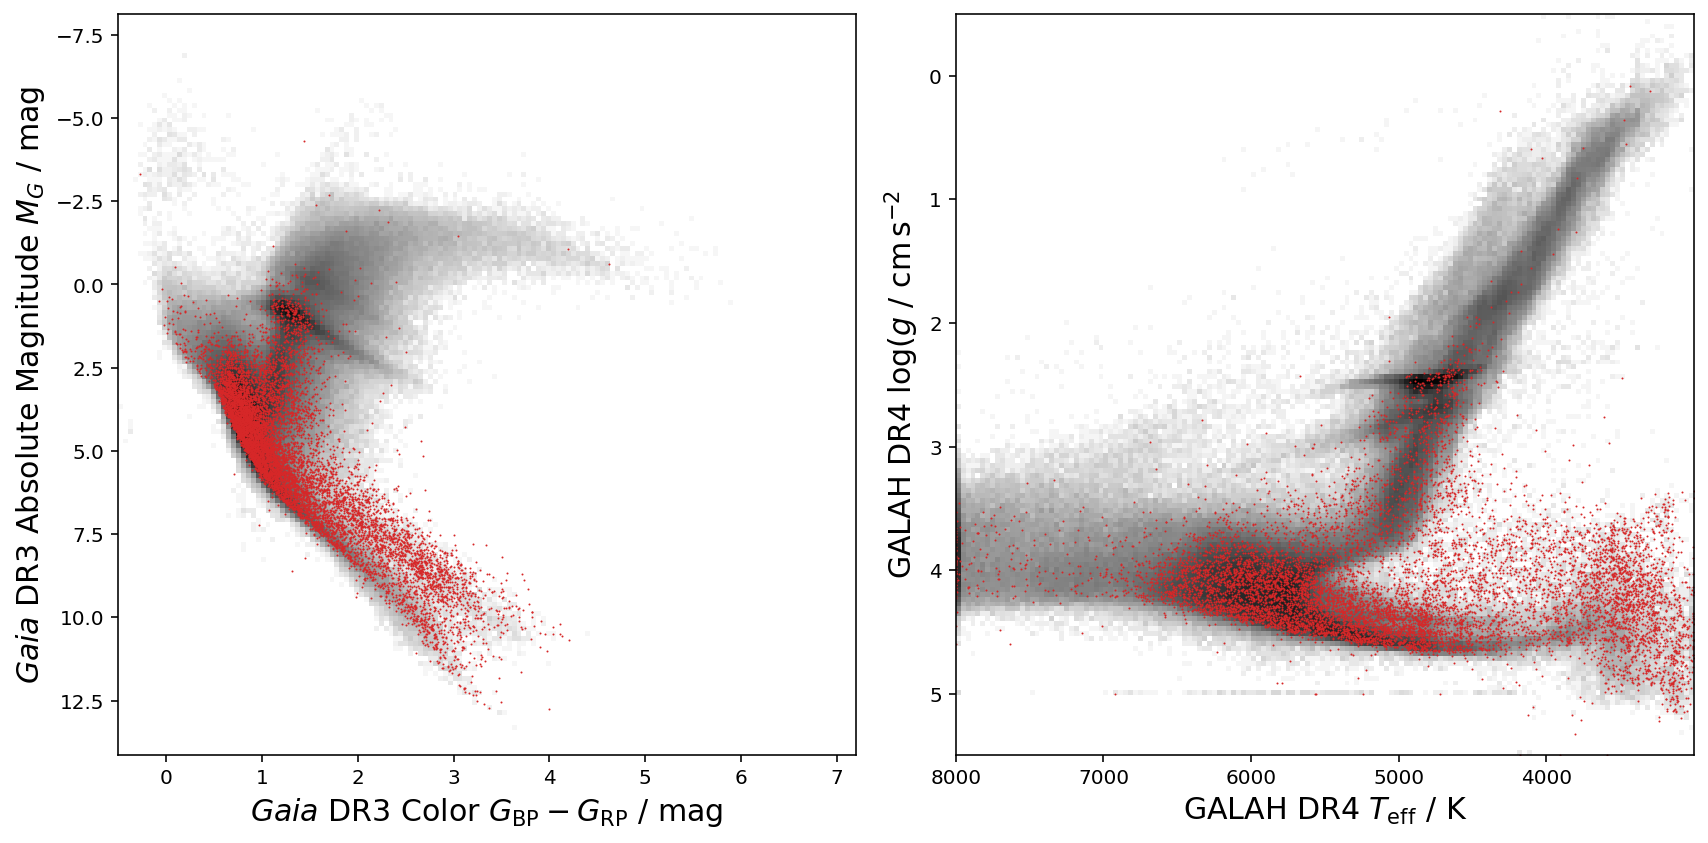

In [8]:
# Where are these stars?
def plot_gaia_hrd_galah_kiel(hrd_xlims = None, hrd_ylims = None, kiel_xlims = None, kiel_ylims = None):
    try:
        finite_distances = np.isfinite(galah_allstar['r_med']) & np.isfinite(galah_allstar['bp_rp'])

        if hrd_ylims is not None:
            size = 3
        else:
            size = 1
            
        f, gs = plt.subplots(1,2,figsize=(12,6))
        ax = gs[0]
        ax.hist2d(
            galah_allstar['bp_rp'][finite_distances],
            galah_allstar['phot_g_mean_mag'][finite_distances] - 5*np.log10(galah_allstar['r_med'][finite_distances]/10),
            bins = 150, norm=LogNorm(),
            cmin = 1, cmap = 'Greys', zorder=1
        );
        ax.scatter(
            galah_coronal['bp_rp'],
            galah_coronal['phot_g_mean_mag'] - 5*np.log10(galah_coronal['r_med']/10),
            s = size, zorder=2, lw=0, c = 'C3'
        );
        if hrd_xlims is not None:
            ax.set_xlim(hrd_xlims)
            
        if hrd_ylims is not None:
            ax.set_ylim(hrd_ylims)
        else:
            ax.set_ylim(ax.get_ylim()[::-1])

        ax.set_xlabel(r'$Gaia$ DR3 Color $G_\mathrm{BP} - G_\mathrm{RP}~/~\mathrm{mag}$',fontsize=15)
        ax.set_ylabel(r'$Gaia$ DR3 Absolute Magnitude $M_G~/~\mathrm{mag}$',fontsize=15)

        ax = gs[1]
        ax.hist2d(
            galah_allstar['teff'][finite_distances],
            galah_allstar['logg'][finite_distances],
            bins = 150, norm=LogNorm(),
            cmin = 1, cmap = 'Greys', zorder=1
        );
        ax.scatter(
            galah_coronal['teff'],
            galah_coronal['logg'],
            s = size, zorder=2, lw=0, c = 'C3'
        );
        if kiel_xlims is not None:
            ax.set_xlim(kiel_xlims)
        else:
            ax.set_xlim(ax.get_xlim()[::-1])
            
        if kiel_ylims is not None:
            ax.set_ylim(kiel_ylims)
        else:
            ax.set_ylim(ax.get_ylim()[::-1])

        ax.set_xlabel(r'GALAH DR4 $T_\mathrm{eff}~/~\mathrm{K}$',fontsize=15)
        ax.set_ylabel(r'GALAH DR4 $\log (g~/~\mathrm{cm\,s^{-2}}$',fontsize=15)
        plt.tight_layout()
        plt.show()
        plt.close()

    except:
        pass
plot_gaia_hrd_galah_kiel()

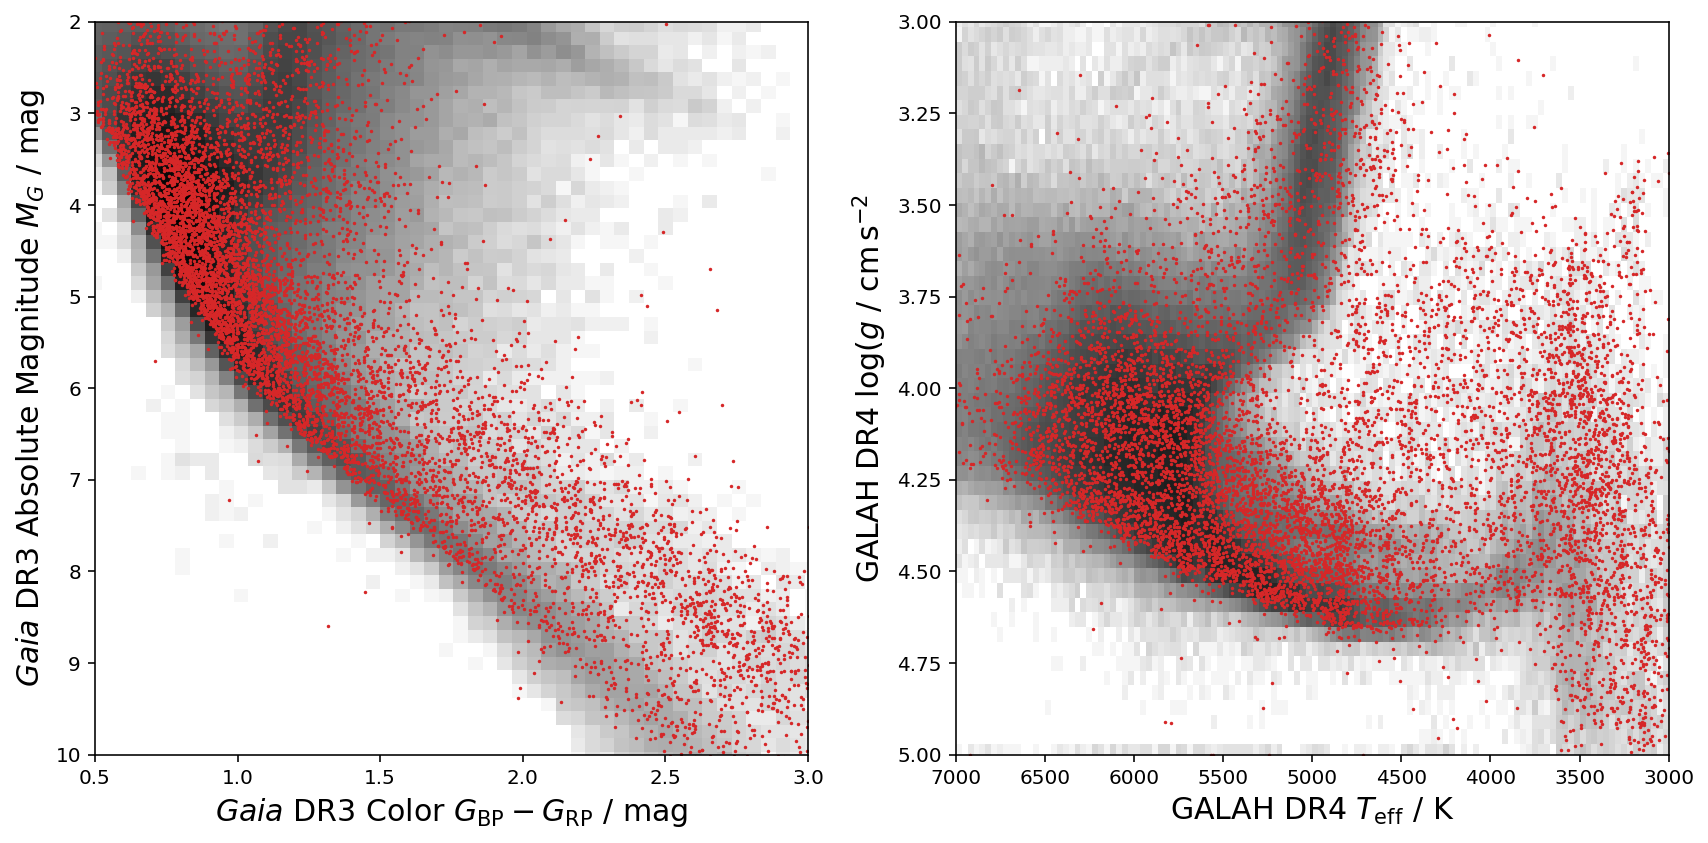

In [9]:
plot_gaia_hrd_galah_kiel(
    hrd_xlims = (0.5,3.), 
    hrd_ylims = (10,2), 
    kiel_xlims = (7000,3000), 
    kiel_ylims = (5.0,3.0)
)
# What can we see?
# Binaries?
# Pre-main-sequence stars?

## 4 Example: eROSITA study of 47 Tuc globular cluster (Saeedi+, 2022)

Paper: https://ui.adsabs.harvard.edu/abs/2022A%26A...661A..35S  
Table: 	J/A+A/661/A35 @ VizieR

In [ ]:
# Download the catalogues from VizieR and join them via common key "No"
tuc47_1 = Vizier.get_catalogs('J/A+A/661/A35/tableb1')[0]
tuc47_3 = Vizier.get_catalogs('J/A+A/661/A35/tableb3')[0]
tuc47 = join(tuc47_1,tuc47_3,keys='No')

# Sadly, the catalogue does not provide the Gaia source_id
# So we have to crossmatch via Ra/Dec and then check that we have consistent Gmag within 1 magnitude

# Use astropy's SkyCoord package to crossmatch.
# First, create SkyCoord objects for both catalogs
coords_tuc47 = SkyCoord(ra=tuc47['RAJ2000'], dec=tuc47['DEJ2000'], unit=(u.hourangle, u.deg))
tuc47['ra'] = coords_tuc47.ra.deg
tuc47['dec'] = coords_tuc47.dec.deg
coords_galah = SkyCoord(ra=galah_allstar['ra'] * u.deg, dec=galah_allstar['dec'] * u.deg)

# Now match the catalogue sources on sky within 5 arcseconds
idx, d2d, _ = coords_tuc47.match_to_catalog_sky(coords_galah)
sep_constraint = d2d < 5 * u.arcsec
cat1_matched = tuc47[sep_constraint]
cat2_matched = galah_allstar[idx[sep_constraint]]

# Doublecheck that the sources have similar magnitudes (to avoid mismatches) and join them
gmag_diff = abs(cat1_matched['Gmag'] - cat2_matched['phot_g_mean_mag'])
mag_constraint = gmag_diff <= 1
final_cat1 = cat1_matched[mag_constraint]
final_cat2 = cat2_matched[mag_constraint]
galah_47tuc_xray = hstack([final_cat1, final_cat2])

len(galah_47tuc_xray)

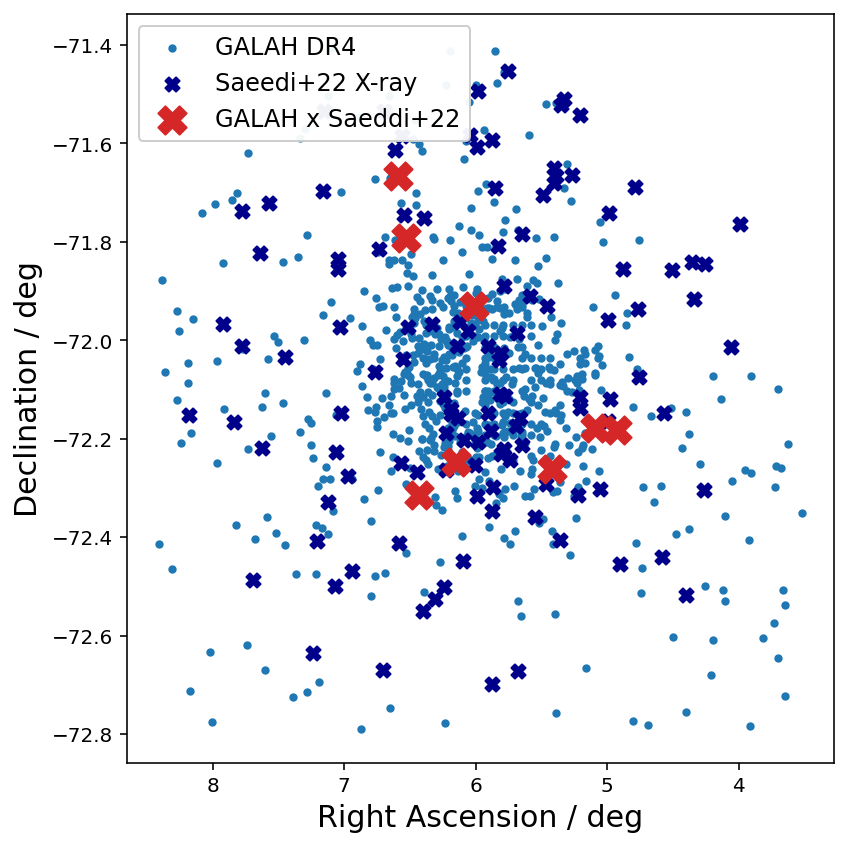

In [13]:
# Where are the stars with X-ray information in 47 Tuc?
def plot_xray_47tuc():
    f, ax = plt.subplots(figsize=(6,6))

    around_47_tuc = (
        (galah_allstar['ra'] > 3.5) & (galah_allstar['ra'] < 8.5) &
        (galah_allstar['dec'] > -72.8) & (galah_allstar['dec'] < -71.4)
    )

    ax.scatter(
        galah_allstar['ra'][around_47_tuc],
        galah_allstar['dec'][around_47_tuc],
        label = 'GALAH DR4',
        c = 'C0',
        s = 10
    )
    ax.scatter(
        tuc47['ra'],
        tuc47['dec'],
        label = 'Saeedi+22 X-ray',
        s = 50,
        c = 'darkblue',
        marker = 'X'
    )
    ax.scatter(
        galah_47tuc_xray['ra_1'],
        galah_47tuc_xray['dec_1'],
        label = 'GALAH x Saeddi+22',
        c = 'C3',
        s = 200,
        marker = 'X'
    )
    ax.legend(loc = 'upper left',fontsize=12,framealpha=0.95)
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_xlabel('Right Ascension / deg',fontsize=15)
    ax.set_ylabel('Declination / deg',fontsize=15)
    plt.tight_layout()
    plt.savefig('figures/47Tuc_stars_xray_or_galah.png',dpi=200,bbox_inches='tight')
plot_xray_47tuc()